In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const
from scipy.optimize import minimize_scalar, curve_fit
from scipy import sparse
import qutip as qt

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import DoubleTweezer, TwoSiteLattice
from boson_helpers import *

# Choose data to analyse

In [2]:
start_line = 334
end_line = 342

n_lines = end_line - start_line + 1
lines = np.arange(start_line,end_line+1,dtype=int)
state_nrs = np.zeros((n_lines,2),dtype=int)
state_nrs[:,1] = 1

degeneracy = np.full(n_lines, True, dtype=bool)

------------------

line: 334
separation: 0.7354 um


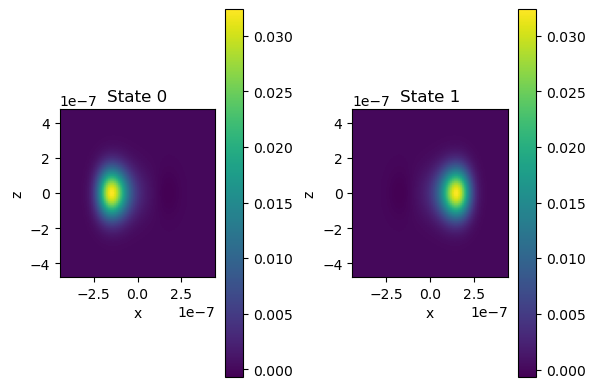

line: 335
separation: 0.7379 um


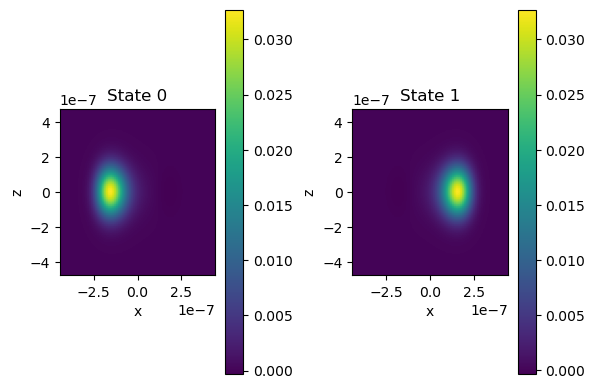

line: 336
separation: 0.7404 um


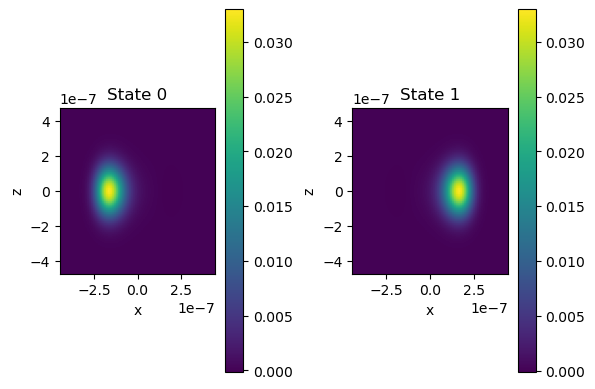

line: 337
separation: 0.7429 um


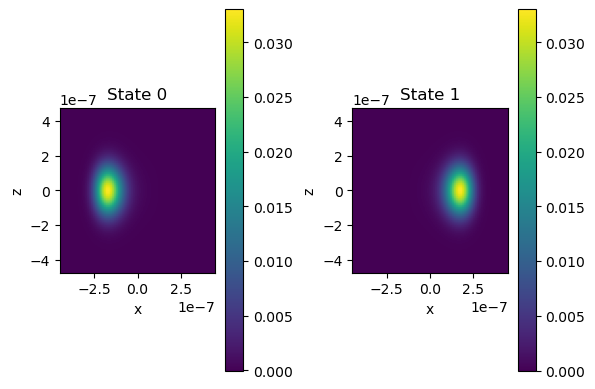

line: 338
separation: 0.7454 um


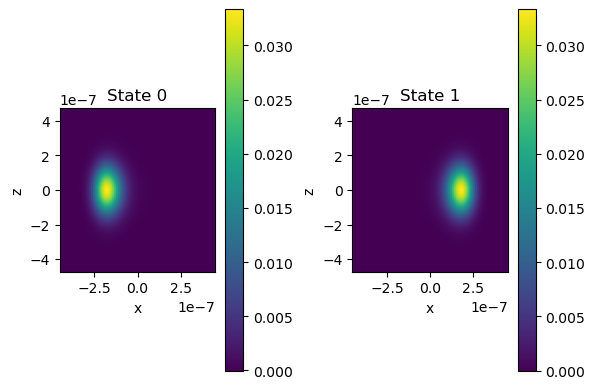

line: 339
separation: 0.7479 um


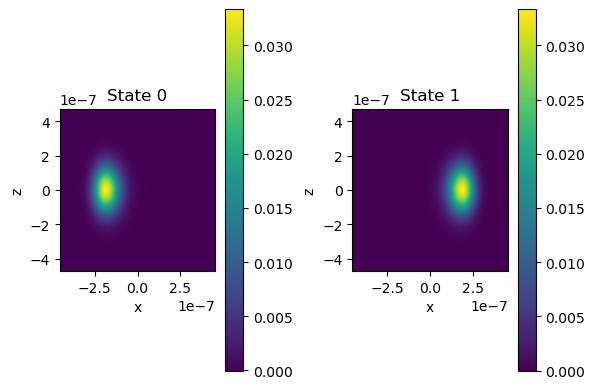

line: 340
separation: 0.7504 um


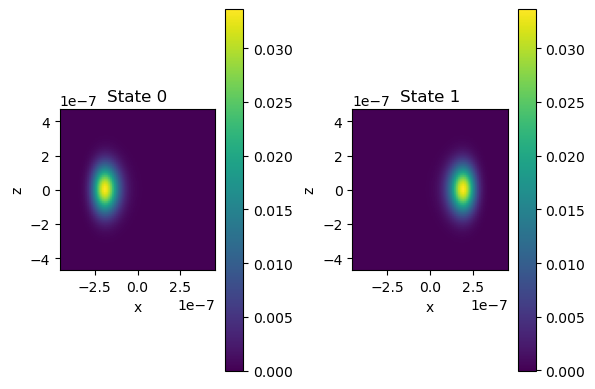

line: 341
separation: 0.7529 um


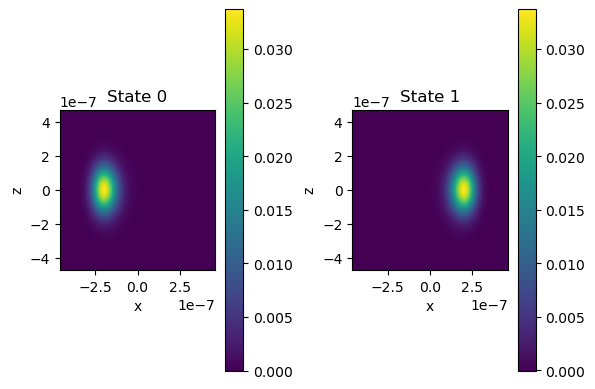

line: 342
separation: 0.7554 um


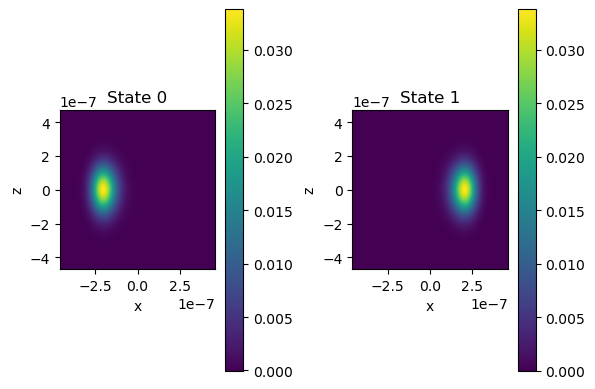

In [3]:
for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]
    
    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    print(f"line: {line}")
    print(f"separation: {trap.subs(trap.distance_tweezers)/si.um:.4f} um")

    #plot wavefunctions
    n_states = 2

    states_plot = [GS_left_1.real, GS_right_1.real]
    #states_plot = [res["states"][state0].real, res["states"][state1].real]
    #states_plot = np.angle(states)
    #states_plot = states.imag
    #states_plot = np.abs(states)**2

    # Create a 1xn_states grid of subplots (1 row, n_states columns)
    fig, axes = plt.subplots(1, n_states, figsize=(6, 4))  # Adjust the size as needed

    # Loop over the state numbers from 0 to n_states-1
    for state_number, ax in zip(range(n_states), axes):
        # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
        im = ax.imshow(states_plot[state_number][:, int(res["size"][1]/2), :].T,
                    extent=[*res["extend"][0], *res["extend"][2]], origin="lower",
                    vmin=np.min(states_plot[state_number]), vmax=np.max(states_plot[state_number]))

        # Set labels for each subplot
        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_title(f"State {state_number}")
        fig.colorbar(im, ax=ax)  

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [4]:
frequencies = np.zeros_like(lines,dtype=float)
distance = np.zeros_like(lines,dtype=float)
J = np.zeros_like(lines,dtype=float)
#tilt = np.zeros_like(lines,dtype=float)
U_s = np.zeros_like(lines,dtype=float)
U_dds = np.zeros((len(lines),50),dtype=float)
angles = np.zeros((len(lines),50),dtype=float)
V_lrs = np.zeros((len(lines),50),dtype=float)
DeltaJs = np.zeros((len(lines),50),dtype=float)

E_exc = np.zeros_like(lines,dtype=float)
E_barr = np.zeros_like(lines,dtype=float)

for i, line in enumerate(lines):
    state0 = state_nrs[i,0]
    state1 = state_nrs[i,1]

    trap, func_ham, res =  import_results(line)
    GS_left_1, GS_right_1 = get_localised_GS(res["states"][state0],
                                             res["states"][state1],
                                             degenerate=degeneracy[i])
    
    frequencies[i] = float(trap.subs(sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m) * 2/trap.waist_tweezer1**2))
    distance[i] = float(trap.subs(trap.distance_tweezers))
    J[i], U_s[i], U_dds[i], angles[i], V_lrs[i], DeltaJs[i] = analyse_diagonalisation(line,
                                                                state_nr0=state0,
                                                                state_nr1=state1,
                                                                degenerate=degeneracy[i],
                                                                n_angles=20)
    
    #estimate energies of 0th and 1st state
    E0 = 0.5*(res["energies"][0] + res["energies"][1])
    E1 = 0.5*(res["energies"][2] + res["energies"][3])
    E_exc[i] = E1-E0

    #estimate heigth of barrier
    V = trap.subs(trap.get_potential(apply_zero_offset=False))
    a = float(trap.subs(trap.distance_tweezers))

    #find minima of potential
    def V_func(x):
        return float(V.subs({trap.x:x, trap.y:0, trap.z:0}))

    x_right = minimize_scalar(V_func,bracket=[0,a]).x
    x_left = minimize_scalar(V_func,bracket=[-a,0]).x

    #catch case where both potentials have already merged
    tunneling_dist = abs(x_right-x_left)
    if tunneling_dist < 1e-15:
        raise Exception("potential has only one minmum")

    #depts of both tweezers
    V_1 = abs(V_func(x_left) - V_func(0))
    V_2 = abs(V_func(x_right) - V_func(0)) 

    E_barr[i] = np.max([V_1,V_2])

    # these states are basically 1 tweezer
    if state1 !=1:
        J[i] = np.nan
        U_s[i] = np.nan
        U_dds[i] = np.nan
        V_lrs[i] = np.nan
        DeltaJs[i] = np.nan
        E_exc[i] = np.nan
        E_barr[i] = np.nan


----------------------

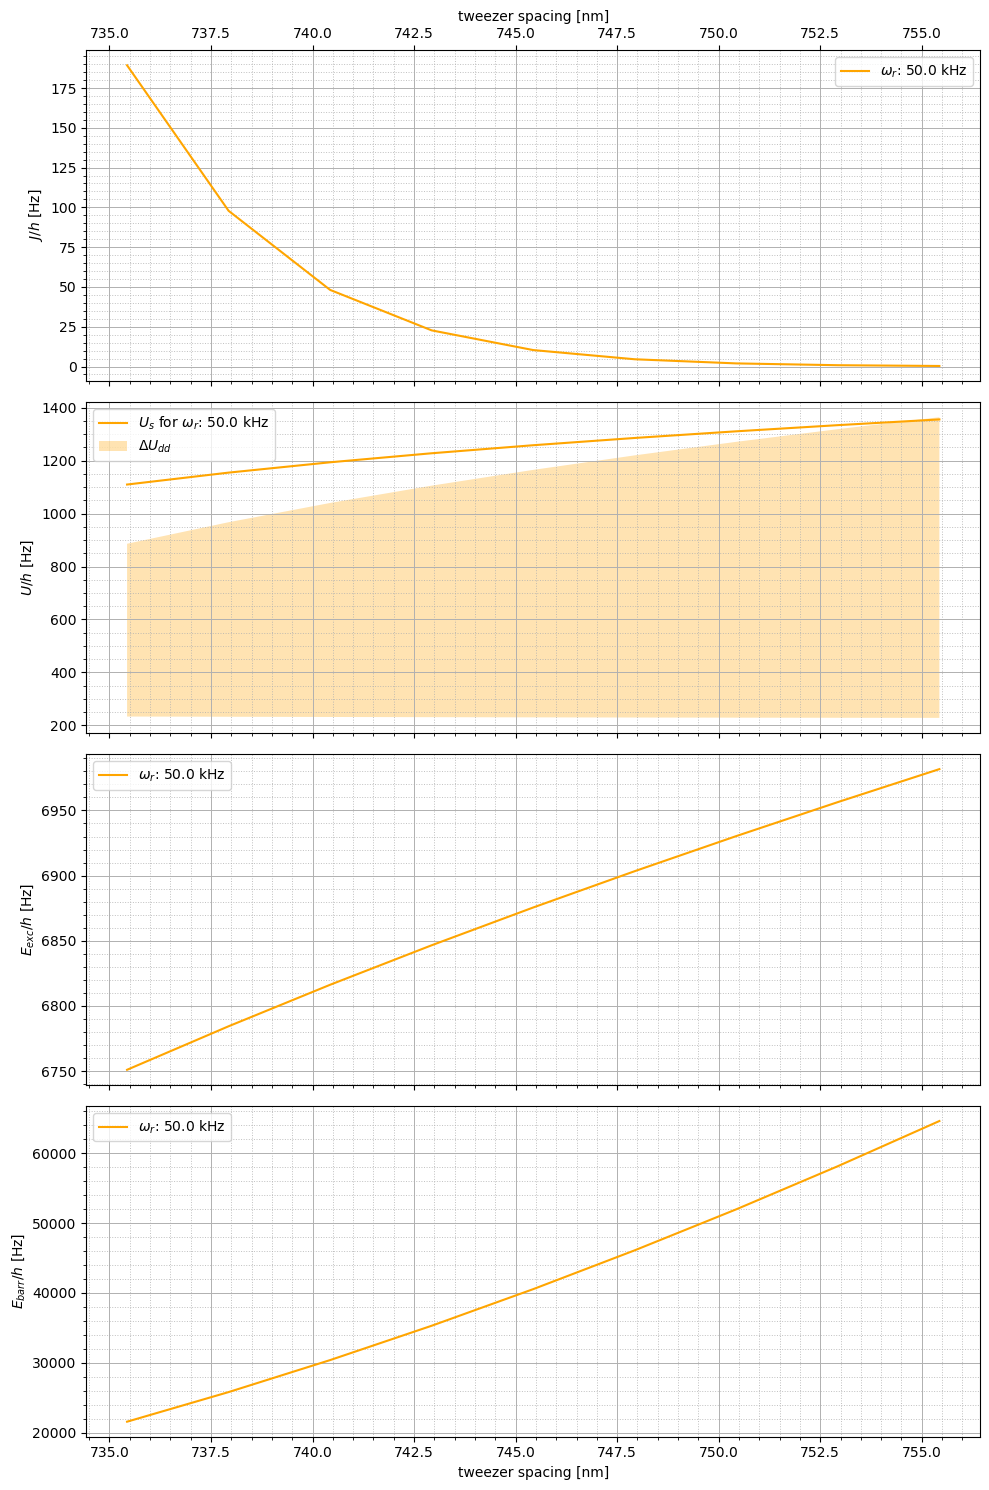

In [5]:
# Create a figure with 4 subplots (stacked vertically)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

# Get unique frequencies
unique_freqs = np.unique(frequencies)

# Define colors for consistency
colors = ["orange", "blue", "green", "purple", "orange"]

### 1️⃣ Hopping parameter J ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[0].plot(distance[mask] / si.nm, J[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

#axes[0].axhspan(50, 150, alpha=0.3, color="gray", label="desired region of 50-100Hz")
axes[0].set_ylabel(r"$J/h$ [Hz]")
axes[0].xaxis.set_label_position('top')
axes[0].set_xlabel("tweezer spacing [nm]")
axes[0].legend()
# 🔹 Add top x-axis ticks
axes[0].tick_params(axis="x", labeltop=True, top=True)
axes[0].grid(True, linestyle='-', linewidth=0.7)
axes[0].minorticks_on()
axes[0].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 2️⃣ Interaction parameter U ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    x = distance[mask] / si.nm
    y = U_s[mask] / const.h
    delta = U_dds[mask] / const.h

    axes[1].plot(x, y, color=color, label=fr"$U_s$ for $\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")
    axes[1].fill_between(x, y + np.min(delta, axis=1), y + np.max(delta, axis=1), 
                         alpha=0.3, color=color, edgecolor=None, label=r"$\Delta U_{dd}$")

axes[1].set_ylabel(r"$U/h$ [Hz]")
axes[1].legend()
axes[1].grid(True, linestyle='-', linewidth=0.7)
axes[1].minorticks_on()
axes[1].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 3️⃣ First excited state energy ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[2].plot(distance[mask] / si.nm, E_exc[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

axes[2].set_ylabel(r"$E_{exc}/h$ [Hz]")
axes[2].legend()
axes[2].grid(True, linestyle='-', linewidth=0.7)
axes[2].minorticks_on()
axes[2].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

### 4️⃣ Barrier height ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes[3].plot(distance[mask] / si.nm, E_barr[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

axes[3].set_ylabel(r"$E_{barr}/h$ [Hz]")
axes[3].set_xlabel("tweezer spacing [nm]")
#axes[3].set_ylim(0, 30000)
axes[3].legend()
axes[3].grid(True, linestyle='-', linewidth=0.7)
axes[3].minorticks_on()
axes[3].grid(True, which='minor', linestyle=':', linewidth=0.7, alpha=0.8)

# Improve layout
plt.tight_layout()
plt.show()


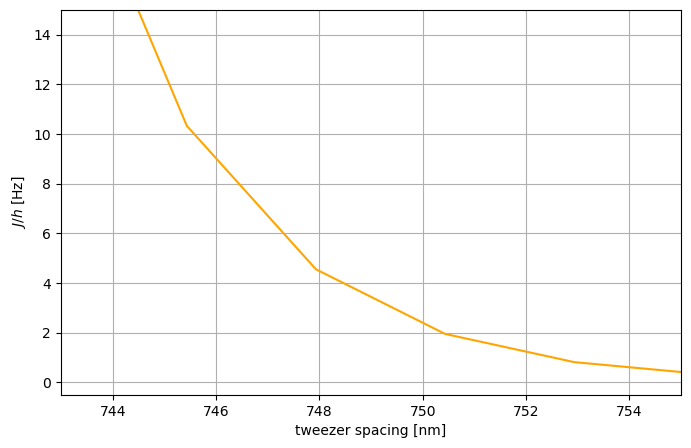

In [26]:
# Create a figure with 4 subplots (stacked vertically)
fig, axes = plt.subplots(figsize=(8, 5))

# Get unique frequencies
unique_freqs = np.unique(frequencies)

# Define colors for consistency
colors = ["orange", "blue", "green", "purple", "orange"]

### 1️⃣ Hopping parameter J ###
for i, (freq, color) in enumerate(zip(unique_freqs, colors)):
    mask = frequencies == freq
    axes.plot(distance[mask] / si.nm, J[mask] / const.h, color=color, 
                 label=fr"$\omega_r$: {freq/2/np.pi/si.kHz:.1f} kHz")

#axes[0].axhspan(50, 150, alpha=0.3, color="gray", label="desired region of 50-100Hz")
axes.set_ylim(-0.5,15)
axes.set_xlim(743,755)
axes.set_ylabel(r"$J/h$ [Hz]")
axes.set_xlabel("tweezer spacing [nm]")
#axes.legend()
axes.grid()
plt.savefig("J_vs_dist.png",dpi=300)
plt.show()